# Peer-graded Assignment: Прогнозирование с помощью регрессии

### Библиотеки

In [142]:
import pickle
from IPython.display import Image
import pandas as pd
from pandas.tseries.holiday import get_calendar, USFederalHolidayCalendar
import numpy as np
import calendar
from time import mktime
from sklearn.linear_model import Lasso as LR
import matplotlib.pyplot as plt
import os
import warnings
from xgboost import XGBRegressor as xgbr
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/feshch/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Берем с Kaggle интересующие нас регионы

In [117]:
kaggle_regions = pd.Series(pd.read_csv('../Week4/sample_solution.csv',\
                                       index_col='id').index).apply(lambda x:x[:4]).value_counts().index

### Данные за 2016

In [122]:
data = pd.DataFrame()
for y in range(2016, 2017, 1):
    data = pd.concat([data, pd.read_csv('data_'+str(y)+'.csv', index_col='Unnamed: 0')])
data.index = pd.to_datetime(data.index)
data = data[[col for col in kaggle_regions]]
data.head()

,1382,1480,1441,1438,1227,1179,1225,1174,1338,1283,...,1183,1734,1076,1281,1436,1175,1733,1533,1173,1327
2016-01-01 00:00:00,22,18,30,38,420,759,14,31,84,413,...,323,44,144,768,70,29,2,39,39,90
2016-01-01 01:00:00,15,37,53,56,613,518,11,71,81,314,...,338,2,211,1062,127,29,5,130,91,147
2016-01-01 02:00:00,10,67,33,52,615,401,25,78,63,148,...,374,0,146,1060,101,22,3,137,75,175
2016-01-01 03:00:00,5,47,44,44,542,391,7,63,44,57,...,410,4,87,614,59,9,2,124,56,176
2016-01-01 04:00:00,4,50,41,27,444,388,2,22,18,52,...,256,1,43,319,73,3,0,113,22,145


### Признаки праздников

In [123]:
cal = get_calendar('USFederalHolidayCalendar')
hld = cal.holidays(pd.datetime(2009, 1, 1), pd.datetime(2016, 6, 30))
data['hol'] = pd.Series(data.index).apply(lambda x: int(x.date() in hld)).values

### Признаки косинусов для недельной сезонности, признак тренда

In [124]:
K=84
p = 2.*pi/168.
for i in range(1, K+1):
    phi = p*i
    data['w_s'+str(i)] = sin(np.array(list(range(0, len(data))))*phi)
    data['w_c'+str(i)] = cos(np.array(list(range(0, len(data))))*phi)
data['trend'] = list(range(len(data)))

# Для буду предсказывать Лассо регрессией по этим признакам, и дальше предсказывать уже не количество поездок, а ошибку прогноза Лассо.
### Лассо, потому что без регуляризации было плохо, иногда выдавала значения на несколько порядков больше нужных

In [147]:
test_lenght = 720

first_history_end = pd.to_datetime('2016-01-01 00:00:00')+datetime.timedelta(hours=train_size)
last_history_end = pd.to_datetime('2016-06-30 17:00:00')
first_forecast_beg = pd.to_datetime('2016-01-01 01:00:00')+datetime.timedelta(hours=train_size)
last_forecast_beg = pd.to_datetime('2016-06-30 18:00:00')
first_forecast_end = pd.to_datetime('2016-01-01 06:00:00')+datetime.timedelta(hours=train_size)
last_forecast_end = pd.to_datetime('2016-06-30 23:00:00')

train_size = 4*168 # Эмпирически выверенный оптимум длины обучающей выборки для наилучшего прогноза
test_size = 6

histends = data.index[(first_history_end<=data.index) & (data.index<=last_history_end)]
forbegs = data.index[(first_forecast_beg<=data.index) & (data.index<=last_forecast_beg)]
forends = data.index[(first_forecast_end<=data.index) & (data.index<=last_forecast_end)]

lr_predictions = pd.DataFrame()
for t, he in enumerate(histends):
    #print(he)
    # Обучающая выборка
    train_X = data[data.index<=he].iloc[-train_size:, 102:]
    # Будем работать с количеством поездок для разных регионов как с вектором
    # чтобы получилась своя модель для каждого региона
    train_y = data[data.index<=he].iloc[-train_size:, :102]
    # Тестовая выборка
    test_X = data.iloc[:, 102:][(forbegs[t]<=data.index) & (data.index<=forends[t])]
    test_y = data.iloc[:, :102][(forbegs[t]<=data.index) & (data.index<=forends[t])]
    # Лассо регрессия
    lr = LR()
    lr.fit(X=train_X, y=train_y)
    lr_pred = pd.DataFrame(data=lr.predict(test_X), columns=test_y.columns, index=test_y.index)
    lr_pred['i'] = range(1, 1+test_size, 1)
    lr_predictions = pd.concat([lr_predictions, lr_pred])

### Так выглядит первый прогноз на вещественных признаках недельной сезонности, тренде и бинарном признаке праздников

In [157]:
lr_predictions.tail(7)

,1382,1480,1441,1438,1227,1179,1225,1174,1338,1283,...,1734,1076,1281,1436,1175,1733,1533,1173,1327,i
2016-06-30 22:00:00,31.307480,8.447399,4.568863,10.249931,308.786402,635.323503,4.467552,34.963519,34.195982,352.030948,...,350.443561,176.991551,1187.898817,30.522199,13.098408,6.352297,11.293366,30.445187,47.184980,6
2016-06-30 18:00:00,33.917467,7.367295,4.568679,10.190568,81.841800,722.411429,4.086638,19.829369,44.257239,447.853703,...,312.451805,210.434492,1007.095746,24.371956,8.452738,6.489372,6.033590,18.062651,3.484965,1
2016-06-30 19:00:00,37.394502,7.183009,4.567658,10.315456,111.672087,792.251845,4.332634,25.346206,40.112396,423.370418,...,311.061735,205.920482,1219.241031,26.470569,10.589743,6.477078,7.203710,20.699244,8.694982,2
2016-06-30 20:00:00,38.506934,7.288691,4.566637,10.426787,155.888542,746.775565,4.511941,30.932935,38.104165,366.956320,...,338.393074,196.171382,1203.951166,28.881981,12.514485,6.452840,8.554710,22.791622,16.166613,3
2016-06-30 21:00:00,36.346916,7.735404,4.565616,10.490433,226.210964,737.026322,4.575779,34.674726,38.499205,384.570490,...,351.032261,194.298925,1320.174509,30.620773,13.511911,6.418451,9.960234,26.493372,29.482247,4
2016-06-30 22:00:00,31.210103,8.426956,4.564595,10.378196,308.883543,635.116900,4.506300,34.933400,34.416359,351.668518,...,350.298001,176.712317,1187.505355,30.725803,13.106886,6.376398,11.274308,30.398980,47.218594,5
2016-06-30 23:00:00,24.341279,9.164517,4.563574,9.967885,380.111364,579.460760,4.321371,31.302501,24.872494,241.116201,...,361.363636,140.388274,884.261472,28.788167,11.302564,6.329688,12.356077,30.288577,60.288914,6


## После буду делать регрессию с помощью XGBoost с целью учёта взаимодействия признаков. Предсказывать буду отклонение от прогноза линейной регрессии. Как признаки буду использовать:
### час, день недели, праздники
### число поездок за последние K=6 часов
### число поездок за неделю до прогноза
### число поездок за неделю до конца истории
### число поездок за Kd=2 дня до прогноза
### число поездок за Kd=2 дня до конца истории
### число поездок в соседних регионах на конце истории (если соседний регион не учитывается на кегле из-за малого количества поездок оттуда, буду использовать значение из самого региона)

## Cнова создаю признаки. Поскольку регрессия быстро учится и предсказывает (относительно XGB), могу позволить для создания признака прогноза регрессии проводить обучение и делать прогноз для каждого конца истории из обучающих данных и теста по-отдельности

## Создаю остальные перечисленные признаки, обучающую, тестовую выборки, данные для прогноза.

In [158]:
first_history_end = pd.to_datetime('2016-01-01 00:00:00')+datetime.timedelta(hours=train_size)
last_history_end = pd.to_datetime('2016-06-30 17:00:00')

histends = data.index[(first_history_end<=data.index) & (data.index<=last_history_end)]

K = 6
Kd = 2
train = []
test = []
submission = []
for i in range(1, 1+test_size, 1):
    TT = pd.DataFrame()
    for r in kaggle_regions:
        he = histends[0]
        train_test = lr_predictions[(lr_predictions.i==i) & (lr_predictions.index<=histends[-1]+\
                                                             datetime.timedelta(hours=i)) & \
                                    (he+datetime.timedelta(hours=-train_size)<lr_predictions.index)][r]
        train_test = pd.DataFrame(train_test)
        # Прогноз регрессии
        train_test.columns = ['lr(i='+str(i)+')']
        # Истинное значение
        train_test['y'] = data[r][train_test.index]
        # Признаки времени суток, дня недели, праздника
        train_test['hour'] = train_test.index.hour.values
        train_test['wd'] = train_test.index.weekday.values
        train_test['hol'] = data.hol[train_test.index]
        # Признаки количества поездок для нескольких последних часов
        for j in range(K):
            train_test['y_T-'+str(j)] = data[r][train_test.index+datetime.timedelta(hours=-i-j)].values
        for j in list(range(1, 1+Kd))+[7]:
            # За несколько дней и за неделю до конца истории
            train_test['y_T-'+str(j*24)] = data[r][train_test.index+datetime.timedelta(hours=-i-j*24)].values
            # За несколько дней и за неделю до прогноза
            train_test['y_T+i-'+str(j*24)] = data[r][train_test.index+datetime.timedelta(hours=-j*24)].values
        # Признаки поездок из соседних регионов для конца истории
        neighbor = str(int(r)+50)
        if neighbor in kaggle_regions:
            train_test['neighbor_0'] = data[neighbor][train_test.index+datetime.timedelta(hours=-i)].values
        else:
            train_test['neighbor_0'] = train_test['y_T-0'].values
        neighbor = str(int(r)-50)
        if neighbor in kaggle_regions:
            train_test['neighbor_1'] = data[neighbor][train_test.index+datetime.timedelta(hours=-i)].values
        else:
            train_test['neighbor_1'] = train_test['y_T-0'].values
        neighbor = str(int(r)+1)
        if neighbor in kaggle_regions:
            train_test['neighbor_2'] = data[neighbor][train_test.index+datetime.timedelta(hours=-i)].values
        else:
            train_test['neighbor_2'] = train_test['y_T-0'].values
        neighbor = str(int(r)-1)
        if neighbor in kaggle_regions:
            train_test['neighbor_3'] = data[neighbor][train_test.index+datetime.timedelta(hours=-i)].values
        else:
            train_test['neighbor_3'] = train_test['y_T-0'].values
        train_test['r'] = int(r)
        TT = pd.concat([TT, train_test])
    train.append(TT[TT.index<pd.to_datetime('2016-05-01 00:00:00')])
    test.append(TT[(TT.index>=pd.to_datetime('2016-04-30 23:00:00')+datetime.timedelta(hours=i)) & \
                   (TT.index<=pd.to_datetime('2016-05-31 17:00:00')+datetime.timedelta(hours=i))])
    submission.append(TT[TT.index>=pd.to_datetime('2016-05-31 23:00:00')+datetime.timedelta(hours=i)])
print("Конец истории: ", he) #Распечатаю пример данных для последней задачи из цикла (i=6) для наглядности
print("Данные для обучения: ")
train[-1].tail()

Конец истории:  2016-01-29 00:00:00
Данные для обучения: 


,lr(i=6),y,hour,wd,hol,y_T-0,y_T-1,y_T-2,y_T-3,y_T-4,...,y_T+i-24,y_T-48,y_T+i-48,y_T-168,y_T+i-168,neighbor_0,neighbor_1,neighbor_2,neighbor_3,r
2016-04-30 19:00:00,31.424744,53,19,5,0,28,16,22,11,8,...,29,2,27,24,45,7,28,28,24,1327
2016-04-30 20:00:00,42.757532,50,20,5,0,23,28,16,22,11,...,18,4,23,20,30,6,23,23,18,1327
2016-04-30 21:00:00,58.837229,37,21,5,0,34,23,28,16,22,...,29,6,30,17,42,5,34,34,19,1327
2016-04-30 22:00:00,78.874458,71,22,5,0,22,34,23,28,16,...,62,4,45,13,46,1,22,22,10,1327
2016-04-30 23:00:00,98.790937,116,23,5,0,31,22,34,23,28,...,90,3,84,23,115,7,31,31,24,1327


## Здесь train, test, submission - массивы трёх частей выборки (обучающей и тестовой для подбора гиперпараметров и итоговой)

In [159]:
# Число концов истории для сабмишшена - 715 для каждого i
[sub.shape[0]/len(kaggle_regions) for sub in submission]

[715.0, 715.0, 715.0, 715.0, 715.0, 715.0]

In [390]:
# Число концов истории для мая - 739 для каждого i
[t.shape[0]/len(kaggle_regions) for t in test

[739.0, 739.0, 739.0, 739.0, 739.0, 739.0]

In [394]:
# С ростом i число доступных из обучающего периода данных уменьшается,
# поскольку длина обучающих данных - это количество обучающих часов плюс отсроченность прогноза
[t.shape[0]/len(kaggle_regions) for t in train]

[2231.0, 2230.0, 2229.0, 2228.0, 2227.0, 2226.0]

In [160]:
for i in range(1, 1+test_size, 1):
    train[i-1].to_csv('Выборки/train_'+str(i)+'.csv')
    test[i-1].to_csv('Выборки/test_'+str(i)+'.csv')
    submission[i-1].to_csv('Выборки/submission_'+str(i)+'.csv')

## Чтобы сильно не перегружать регрессор и быть уверенным релевантности найденных гиперпараметров, из обучающих данных оставлю столько же, сколько есть тестовых:

In [161]:
for i in range(1, 1+test_size, 1):
    b = sorted(train[i-1].index.value_counts().index)[-len(test[0])//len(kaggle_regions):]
    b_ = b[0]
    _b = b[-1]
    train[i-1] = train[i-1][(train[i-1].index<=_b) & (train[i-1].index>=b_)]
    print(train[i-1].shape[0]/len(kaggle_regions))

739.0
739.0
739.0
739.0
739.0
739.0


## Делать признак региона категориальным оказалось не такой хорошей идеей, как предсказывать для каждого региона отдельным регрессором, поскольку регионов в разы больше, чем признаков. Тем не менее, гиперпараметры буду настраивать вместе, это должно помочь избежать переобучения гиперпараметров.
# Настройка гиперпараметров:
#### Процедура с https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

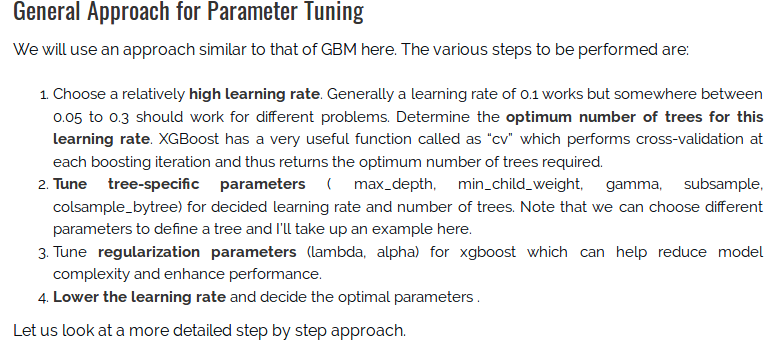

In [175]:
Image(filename='Снимок экрана от 2018-05-16 01-52-02.png')

## Выбор относительно большого learning_rate:

[0.005000000000000002, 14.271200784302515]
[0.006974753969812107, 14.079578233960921]
[0.009729438587881946, 13.930615601656571]
[0.013572088082974535, 13.827601249111071]
[0.01893239504707324, 13.799760978797655]
[0.02640975950252502, 13.86706184800911]
[0.03684031498640388, 13.942456213548274]
[0.05139042664010977, 14.069830053797295]
[0.07168711644368866, 14.165930752766164]
[0.10000000000000002, 14.32210045243337]
CPU times: user 6min 30s, sys: 404 ms, total: 6min 31s
Wall time: 2min 11s


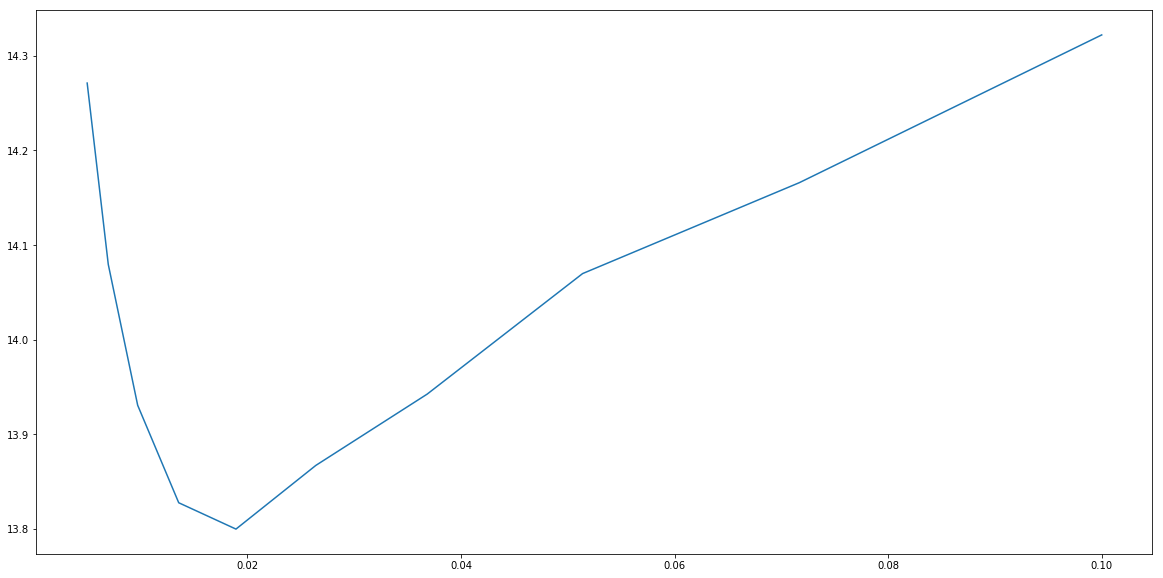

In [174]:
%%time
params = np.exp(np.linspace(np.log(0.005), np.log(0.1), 10))
graph = []
for param in params:
    xgb = xgbr(max_depth=150,
               n_estimators=100,
               subsample=0.63,
               nthread=3,
               learning_rate=param)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:10]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([param, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
plt.figure(figsize=(20,10))
plt.plot(graph[:, 0], graph[:, 1])

## Выбор n_estimators:

[1, 15.111338554529851]
[2, 15.028638767988074]
[3, 14.950074035587619]
[4, 14.887159006509735]
[7, 14.70407207265555]
[10, 14.544508204286798]
[15, 14.335847014206285]
[20, 14.18161163436531]
[30, 13.99263490603214]
[40, 13.881540468180356]
[60, 13.81900448340444]
[80, 13.837853037995114]
[100, 13.877061911189365]
[125, 13.923006510972137]
[150, 13.960988706935442]
[175, 13.987497158396378]
[200, 14.002479012626692]
CPU times: user 7min 3s, sys: 820 ms, total: 7min 4s
Wall time: 2min 23s


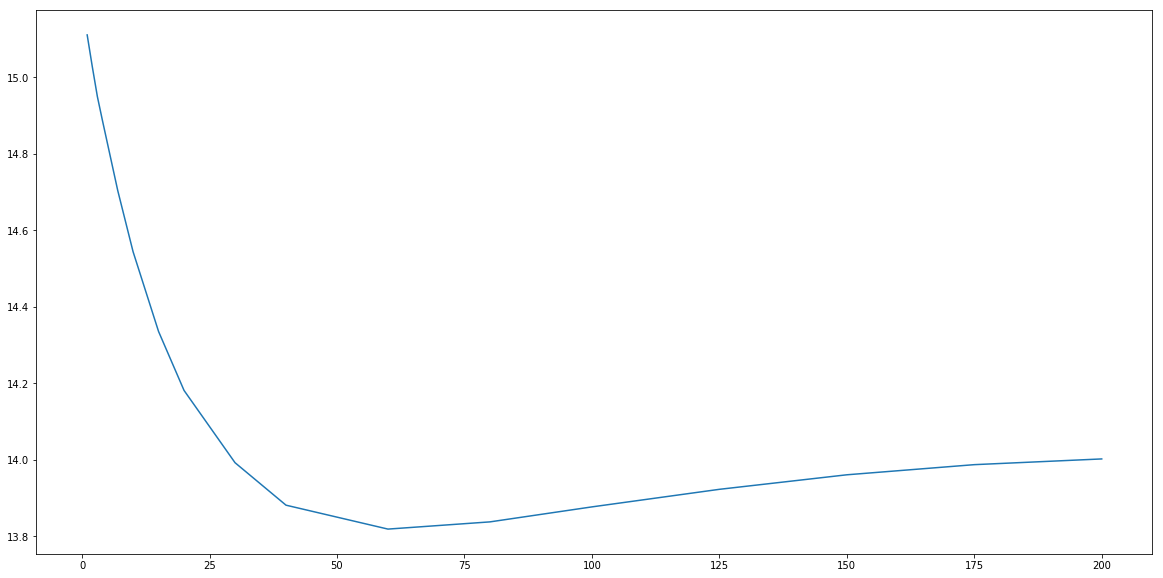

In [229]:
%%time
params = [1, 2, 3, 4, 7, 10, 15, 20, 30, 40, 60, 80, 100, 125, 150, 175, 200]
graph = []
for param in params:
    xgb = xgbr(max_depth=150,
               n_estimators=param,
               subsample=0.63,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:10]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([param, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
n_estimators = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
plt.figure(figsize=(20,10))
plt.plot(graph[:, 0], graph[:, 1])

[35, 19.60321930280681]
[37, 19.586716423173755]
[39, 19.572923990346585]
[41, 19.56579598631769]
[43, 19.558985479946557]
[45, 19.552091641694282]
[47, 19.548664667757187]
[49, 19.54582047161787]
[51, 19.547125358545046]
[53, 19.548091420516517]
[55, 19.552028197543905]
CPU times: user 34min 16s, sys: 3.38 s, total: 34min 20s
Wall time: 11min 35s


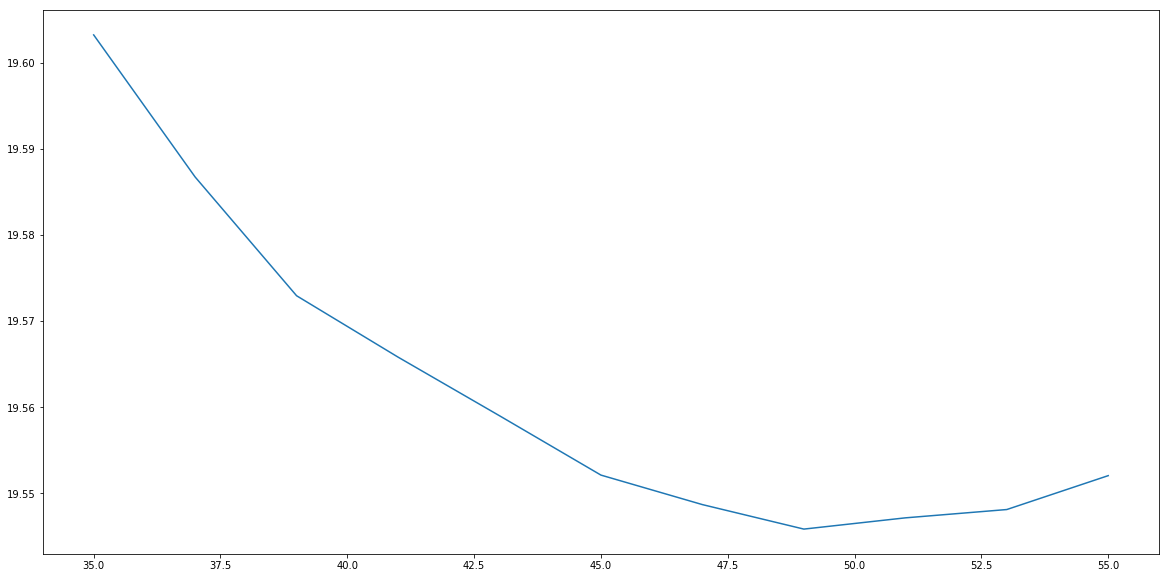

In [231]:
%%time
params = range(35, 57, 2)
graph = []
for param in params:
    xgb = xgbr(max_depth=150,
               n_estimators=param,
               subsample=0.63,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([param, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
n_estimators = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
plt.figure(figsize=(20,10))
plt.plot(graph[:, 0], graph[:, 1])

[48, 19.547259299349932]
[49, 19.54582047161787]
[50, 19.545993510957906]
CPU times: user 10min 21s, sys: 1.26 s, total: 10min 22s
Wall time: 3min 31s


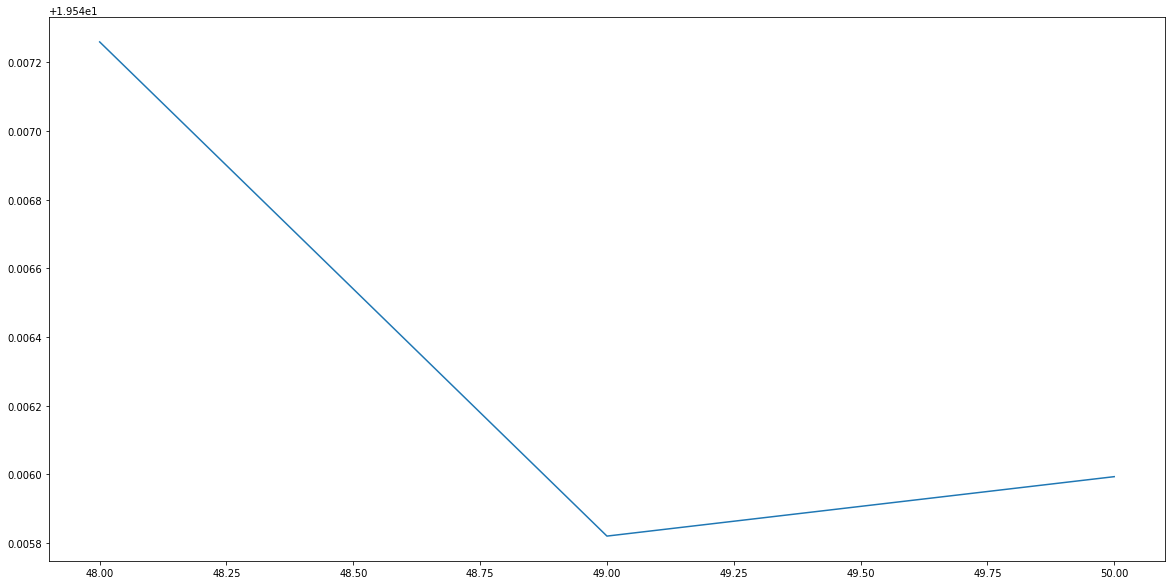

In [289]:
%%time
graph = []
params = [48, 49, 50]
for param in params:
    xgb = xgbr(max_depth=150,
               n_estimators=param,
               subsample=0.63,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([param, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
n_estimators = int(graph[:, 0][graph[:, 1]==min(graph[:, 1])][0])
plt.figure(figsize=(20,10))
plt.plot(graph[:, 0], graph[:, 1])

## Выбор max_depth, min_child_weight:

In [306]:
%%time
max_depth=[20, 30, 50, 80, 110, 150, 200, 275, 400]
min_child_weight=[1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50]
parameters_list = list(itertools.product(max_depth, min_child_weight))
print("Количество комбинаций параметров: %d" % len(parameters_list))

graph = []
for params in parameters_list:
    xgb = xgbr(max_depth=params[0],
               min_child_weight=params[1],
               gamma=0,
               subsample=0.6,
               colsample_bytree=0.76,
               n_estimators=n_estimators,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:10]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([params, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
best_params = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
print(best_params)
max_depth=best_params[0]
min_child_weight=best_params[1]

Количество комбинаций параметров: 99
[(20, 1), 13.829459675765262]
[(20, 2), 13.80594509369954]
[(20, 3), 13.768900618310607]
[(20, 4), 13.753967142985811]
[(20, 5), 13.75214588511655]
[(20, 7), 13.74756480137106]
[(20, 10), 13.747059711540134]
[(20, 15), 13.787153241673227]
[(20, 20), 13.843339856459767]
[(20, 30), 13.958617951740353]
[(20, 50), 14.113578140488876]
[(30, 1), 13.817105458004383]
[(30, 2), 13.805769453469631]
[(30, 3), 13.777998307336311]
[(30, 4), 13.750356443604272]
[(30, 5), 13.756630352626745]
[(30, 7), 13.74795963671207]
[(30, 10), 13.747059711540134]
[(30, 15), 13.787153241673227]
[(30, 20), 13.843339856459767]
[(30, 30), 13.958617951740353]
[(30, 50), 14.113578140488876]
[(50, 1), 13.816880677615357]
[(50, 2), 13.807433753482972]
[(50, 3), 13.777998307336311]
[(50, 4), 13.750356443604272]
[(50, 5), 13.756630352626745]
[(50, 7), 13.74795963671207]
[(50, 10), 13.747059711540134]
[(50, 15), 13.787153241673227]
[(50, 20), 13.843339856459767]
[(50, 30), 13.95861795174

In [324]:
%%time
max_depth=range(15, 27, 2)
min_child_weight=range(7, 15, 2)
parameters_list = list(itertools.product(max_depth, min_child_weight))
print("Количество комбинаций параметров: %d" % len(parameters_list))

graph = []
for params in parameters_list:
    xgb = xgbr(max_depth=params[0],
               min_child_weight=params[1],
               gamma=0,
               subsample=0.6,
               colsample_bytree=0.76,
               n_estimators=n_estimators,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([params, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
best_params = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
print(best_params)
max_depth=best_params[0]
min_child_weight=best_params[1]

Количество комбинаций параметров: 24
[(15, 7), 19.43536437235713]
[(15, 9), 19.428956709937086]
[(15, 11), 19.43953447343494]
[(15, 13), 19.453959255518164]
[(17, 7), 19.433112918221354]
[(17, 9), 19.428206558642046]
[(17, 11), 19.438022841812348]
[(17, 13), 19.453742873150595]
[(19, 7), 19.43441850133086]
[(19, 9), 19.428507850333215]
[(19, 11), 19.438035476375006]
[(19, 13), 19.4532322413372]
[(21, 7), 19.434678576888825]
[(21, 9), 19.428370475001874]
[(21, 11), 19.438115250081573]
[(21, 13), 19.453172594912097]
[(23, 7), 19.43456536186829]
[(23, 9), 19.42832657129441]
[(23, 11), 19.43811290102017]
[(23, 13), 19.453172594912097]
[(25, 7), 19.434566723604743]
[(25, 9), 19.428266338294094]
[(25, 11), 19.43811290102017]
[(25, 13), 19.453172594912097]
(17, 9)
CPU times: user 39min 39s, sys: 6.46 s, total: 39min 46s
Wall time: 13min 28s


In [325]:
%%time
max_depth=range(best_params[0]-1, best_params[0]+2, 1)
min_child_weight=range(best_params[1]-1, best_params[1]+2, 1)
parameters_list = list(itertools.product(max_depth, min_child_weight))
print("Количество комбинаций параметров: %d" % len(parameters_list))

graph = []
for params in parameters_list:
    xgb = xgbr(max_depth=params[0],
               min_child_weight=params[1],
               gamma=0,
               subsample=0.6,
               colsample_bytree=0.76,
               n_estimators=n_estimators,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([params, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
best_params = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
print(best_params)
max_depth=best_params[0]
min_child_weight=best_params[1]

Количество комбинаций параметров: 9
[(16, 8), 19.43180616138511]
[(16, 9), 19.42975261379327]
[(16, 10), 19.42962196195218]
[(17, 8), 19.435391358743058]
[(17, 9), 19.428206558642046]
[(17, 10), 19.429011000374494]
[(18, 8), 19.436330044055545]
[(18, 9), 19.429259875897806]
[(18, 10), 19.428449543880678]
(17, 9)
CPU times: user 15min 58s, sys: 3.69 s, total: 16min 2s
Wall time: 5min 31s


## Выбор gamma:

[0.0, 19.482799631597818]
[10.0, 19.482646929393987]
[20.0, 19.48283984866712]
[30.000000000000004, 19.48332200911704]
[40.0, 19.484989575581768]
[50.0, 19.48681300911421]
10.0
CPU times: user 8min 28s, sys: 2.04 s, total: 8min 30s
Wall time: 2min 55s


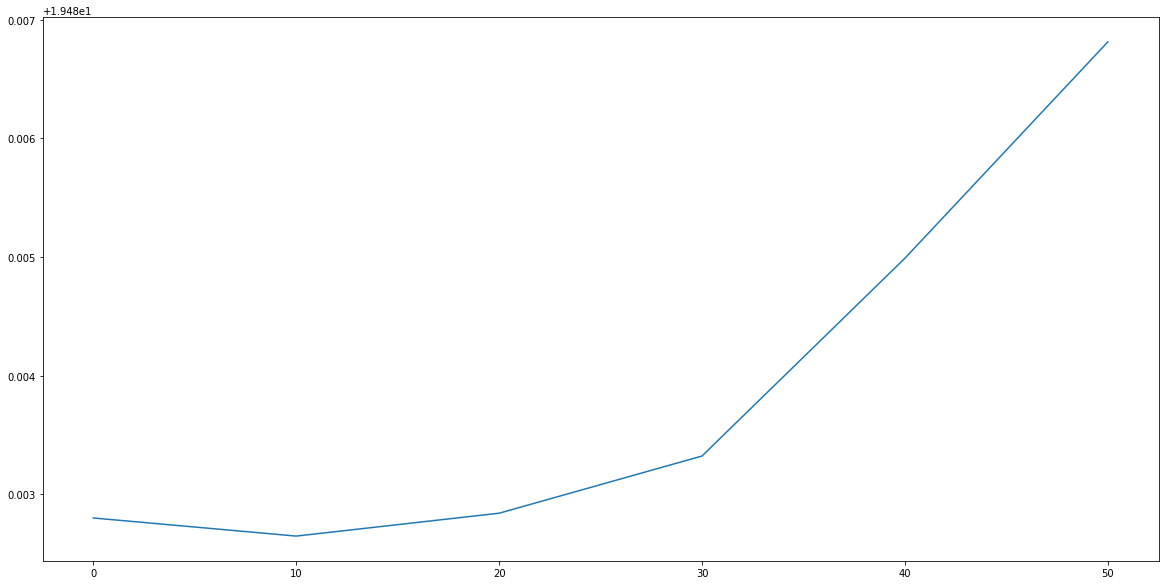

In [326]:
%%time
graph = []
for gamma in np.linspace(0., 0.5, 6)*100:
    xgb = xgbr(max_depth=max_depth,
               min_child_weight=max_depth,
               gamma=gamma,
               subsample=0.6,
               colsample_bytree=0.76,
               n_estimators=n_estimators,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([gamma, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
gamma = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
print(gamma)
plt.figure(figsize=(20,10))
plt.plot(graph[:, 0], graph[:, 1])

[5.0, 19.482653739680128]
[7.0, 19.48271827824545]
[9.0, 19.482709910937153]
[11.0, 19.482612485390362]
[13.0, 19.482643983151256]
[15.0, 19.48260646363536]
15.0
CPU times: user 8min 36s, sys: 2.22 s, total: 8min 38s
Wall time: 2min 58s


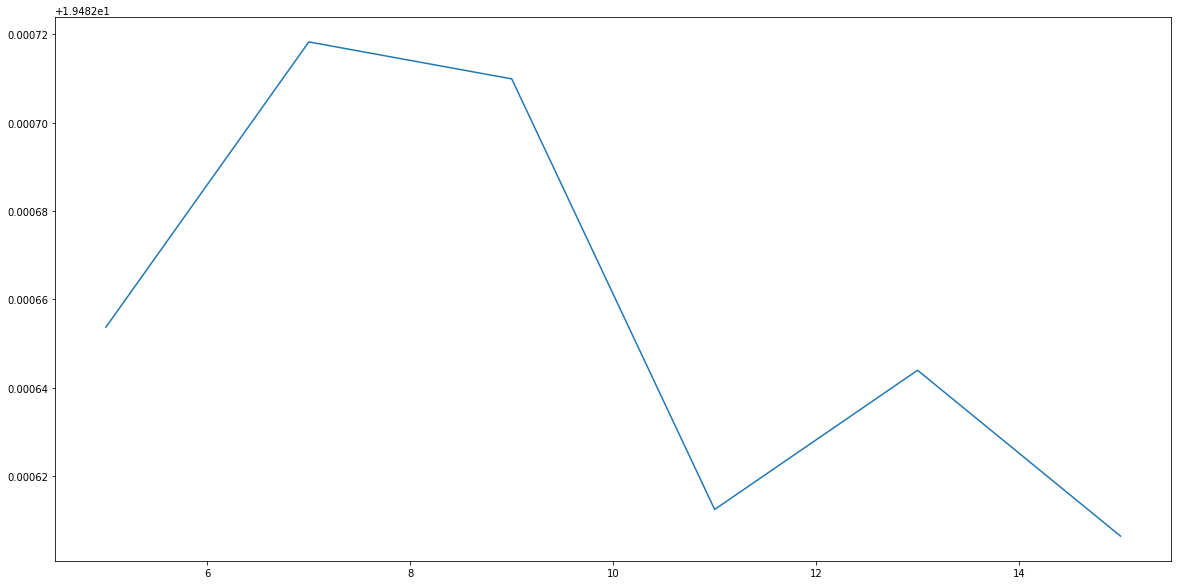

In [327]:
%%time
graph = []
for gamma in np.linspace(5, 15, 6):
    xgb = xgbr(max_depth=max_depth,
               min_child_weight=max_depth,
               gamma=gamma,
               subsample=0.6,
               colsample_bytree=0.76,
               n_estimators=n_estimators,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([gamma, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
gamma = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
print(gamma)
plt.figure(figsize=(20,10))
plt.plot(graph[:, 0], graph[:, 1])

### Тут можно дальше пока сильно не  улучшать gamma, поскольку в MAE меняется довольно далёкий знак после запятой
## Выбор subsample, colsample_bytree:

In [328]:
%%time
subsample=np.linspace(0.4, 1., 13)
colsample_bytree=np.linspace(9./19+0.01, 1., 11)

parameters_list = list(itertools.product(subsample, colsample_bytree))
print("Количество комбинаций параметров: %d" % len(parameters_list))

graph = []
for params in parameters_list:
    xgb = xgbr(max_depth=max_depth,
               min_child_weight=min_child_weight,
               gamma=gamma,
               subsample=params[0],
               colsample_bytree=params[1],
               n_estimators=n_estimators,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:10]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([params, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
best_params = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
print(best_params)
subsample=best_params[0]
colsample_bytree=best_params[1]

Количество комбинаций параметров: 143
[(0.4, 0.48368421052631577), 13.921148212036268]
[(0.4, 0.5353157894736842), 13.904022048918538]
[(0.4, 0.5869473684210527), 13.850694047721825]
[(0.4, 0.6385789473684211), 13.84396239919807]
[(0.4, 0.6902105263157895), 13.791680883583513]
[(0.4, 0.7418421052631579), 13.791301864927725]
[(0.4, 0.7934736842105263), 13.784692960619537]
[(0.4, 0.8451052631578948), 13.80547484341806]
[(0.4, 0.8967368421052633), 13.795089916143525]
[(0.4, 0.9483684210526316), 13.796403812116608]
[(0.4, 1.0), 13.791101434954191]
[(0.45, 0.48368421052631577), 13.88490964516953]
[(0.45, 0.5353157894736842), 13.853239458961896]
[(0.45, 0.5869473684210527), 13.80457978244911]
[(0.45, 0.6385789473684211), 13.797191389299483]
[(0.45, 0.6902105263157895), 13.77003775865319]
[(0.45, 0.7418421052631579), 13.751477103028465]
[(0.45, 0.7934736842105263), 13.744790400343158]
[(0.45, 0.8451052631578948), 13.749790621004855]
[(0.45, 0.8967368421052633), 13.773339638303808]
[(0.45, 0.9

In [335]:
%%time
subsample=np.linspace(best_params[0]-0.05, best_params[0]+0.05, 6)
colsample_bytree=np.linspace(-2./19+best_params[1], 2./19+best_params[1], 5)

parameters_list = list(itertools.product(subsample, colsample_bytree))
print("Количество комбинаций параметров: %d" % len(parameters_list))

graph = []
for params in parameters_list:
    xgb = xgbr(max_depth=max_depth,
               min_child_weight=min_child_weight,
               gamma=gamma,
               subsample=params[0],
               colsample_bytree=params[1],
               n_estimators=n_estimators,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([params, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
best_params = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
print(best_params)
subsample=best_params[0]
colsample_bytree=best_params[1]

Количество комбинаций параметров: 30
[(0.7, 0.6882105263157895), 19.427886438188093]
[(0.7, 0.740842105263158), 19.416659816654942]
[(0.7, 0.7934736842105263), 19.415300847464906]
[(0.7, 0.8461052631578947), 19.422471762935736]
[(0.7, 0.8987368421052632), 19.4304779131021]
[(0.72, 0.6882105263157895), 19.42898447529826]
[(0.72, 0.740842105263158), 19.424848479557742]
[(0.72, 0.7934736842105263), 19.42210845747904]
[(0.72, 0.8461052631578947), 19.42667891891976]
[(0.72, 0.8987368421052632), 19.42756303269399]
[(0.74, 0.6882105263157895), 19.40927731422214]
[(0.74, 0.740842105263158), 19.420369517308302]
[(0.74, 0.7934736842105263), 19.420975703887287]
[(0.74, 0.8461052631578947), 19.422988708644617]
[(0.74, 0.8987368421052632), 19.422789794254886]
[(0.76, 0.6882105263157895), 19.42301001913621]
[(0.76, 0.740842105263158), 19.417148202180115]
[(0.76, 0.7934736842105263), 19.4148759145193]
[(0.76, 0.8461052631578947), 19.427086893545408]
[(0.76, 0.8987368421052632), 19.436979641509538]
[(

## Выбор регуляризаторов: reg_lambda, reg_alpha:

In [336]:
%%time
reg_lambda=[1e-5, 1e-2, 0.1, 1, 100]
reg_alpha=[1e-5, 1e-2, 0.1, 1, 100]
parameters_list = list(itertools.product(reg_lambda, reg_alpha))
print("Количество комбинаций параметров: %d" % len(parameters_list))

graph = []
for params in parameters_list:
    xgb = xgbr(max_depth=max_depth,
               min_child_weight=min_child_weight,
               gamma=gamma,
               subsample=subsample,
               colsample_bytree=colsample_bytree,
               reg_lambda=params[0],
               reg_alpha=params[1],
               n_estimators=n_estimators,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:10]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([params, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
best_params = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
print(best_params)
reg_lambda=best_params[0]
reg_alpha=best_params[1]

Количество комбинаций параметров: 25
[(1e-05, 1e-05), 13.699946972703966]
[(1e-05, 0.01), 13.700240368718022]
[(1e-05, 0.1), 13.699367779767778]
[(1e-05, 1), 13.702475925874626]
[(1e-05, 100), 13.95937582161916]
[(0.01, 1e-05), 13.701230100115454]
[(0.01, 0.01), 13.702033479171822]
[(0.01, 0.1), 13.704814230324901]
[(0.01, 1), 13.711190484272462]
[(0.01, 100), 13.96211681941788]
[(0.1, 1e-05), 13.699162958359342]
[(0.1, 0.01), 13.699288712692885]
[(0.1, 0.1), 13.699676158670966]
[(0.1, 1), 13.702028991079288]
[(0.1, 100), 13.959689551843768]
[(1, 1e-05), 13.712673561092005]
[(1, 0.01), 13.713691895815833]
[(1, 0.1), 13.717774090828245]
[(1, 1), 13.721408286865321]
[(1, 100), 13.963364201767876]
[(100, 1e-05), 14.295843582312841]
[(100, 0.01), 14.295852925773092]
[(100, 0.1), 14.295861355527531]
[(100, 1), 14.296461599686]
[(100, 100), 14.385654471030513]
(0.1, 1e-05)
CPU times: user 3min 59s, sys: 604 ms, total: 4min
Wall time: 1min 21s


In [339]:
%%time
reg_lambda=[0.01, 0.03, 0.1, 0.3, 0.5, 1.]
reg_alpha=[0, 0.01, 0.03, 0.1]
parameters_list = list(itertools.product(reg_lambda, reg_alpha))
print("Количество комбинаций параметров: %d" % len(parameters_list))
graph = []
for params in parameters_list:
    xgb = xgbr(max_depth=max_depth,
               min_child_weight=min_child_weight,
               gamma=gamma,
               subsample=subsample,
               colsample_bytree=colsample_bytree,
               reg_lambda=params[0],
               reg_alpha=params[1],
               n_estimators=n_estimators,
               nthread=3,
               learning_rate=0.03)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([params, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
best_params = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
print(best_params)
reg_lambda=best_params[0]
reg_alpha=best_params[1]

Количество комбинаций параметров: 24
[(0.01, 0), 19.419906735341815]
[(0.01, 0.01), 19.41983100415527]
[(0.01, 0.03), 19.41983011204678]
[(0.01, 0.1), 19.42152720306795]
[(0.03, 0), 19.419937066935052]
[(0.03, 0.01), 19.419395105051777]
[(0.03, 0.03), 19.41957451266491]
[(0.03, 0.1), 19.419183905004147]
[(0.1, 0), 19.418941102621]
[(0.1, 0.01), 19.418967802539786]
[(0.1, 0.03), 19.420161147615847]
[(0.1, 0.1), 19.418304358005653]
[(0.3, 0), 19.41949973524067]
[(0.3, 0.01), 19.41881977206188]
[(0.3, 0.03), 19.418248158823747]
[(0.3, 0.1), 19.4184443216335]
[(0.5, 0), 19.417181440774286]
[(0.5, 0.01), 19.417887874466768]
[(0.5, 0.03), 19.416905175652083]
[(0.5, 0.1), 19.415985459153646]
[(1.0, 0), 19.40927731422214]
[(1.0, 0.01), 19.40883339215898]
[(1.0, 0.03), 19.409424990959682]
[(1.0, 0.1), 19.410123324376208]
(1.0, 0.01)
CPU times: user 46min 24s, sys: 8.23 s, total: 46min 32s
Wall time: 15min 59s


[0.03, 19.457358433551544]
[0.028999999999999998, 19.465726120985817]
[0.027999999999999997, 19.470711101258885]
[0.027, 19.483940666008632]
[0.026, 19.49569307672684]
[0.024999999999999998, 19.506941524463606]
[0.024, 19.52247487550121]
[0.023, 19.539096265175953]
[0.022, 19.56099094144491]
[0.020999999999999998, 19.578408259411304]
[0.019999999999999997, 19.601989185306188]
[0.019, 19.628678819237052]
[0.018, 19.65876405805001]
[0.016999999999999998, 19.689965454909707]
[0.016, 19.72376488729166]
[0.015, 19.761798351382538]
[0.013999999999999999, 19.802630535667603]
[0.012999999999999998, 19.847105059855103]
[0.011999999999999997, 19.897088881472715]
[0.011, 19.950782136893334]
[0.009999999999999998, 20.00895957095302]
[0.008999999999999998, 20.07304427043396]
[0.008, 20.14240830328439]
[0.006999999999999999, 20.21814859145109]
[0.005999999999999998, 20.300131438154114]
[0.0049999999999999975, 20.388371873139857]
[0.003999999999999997, 20.484486621611318]
[0.002999999999999999, 20.58

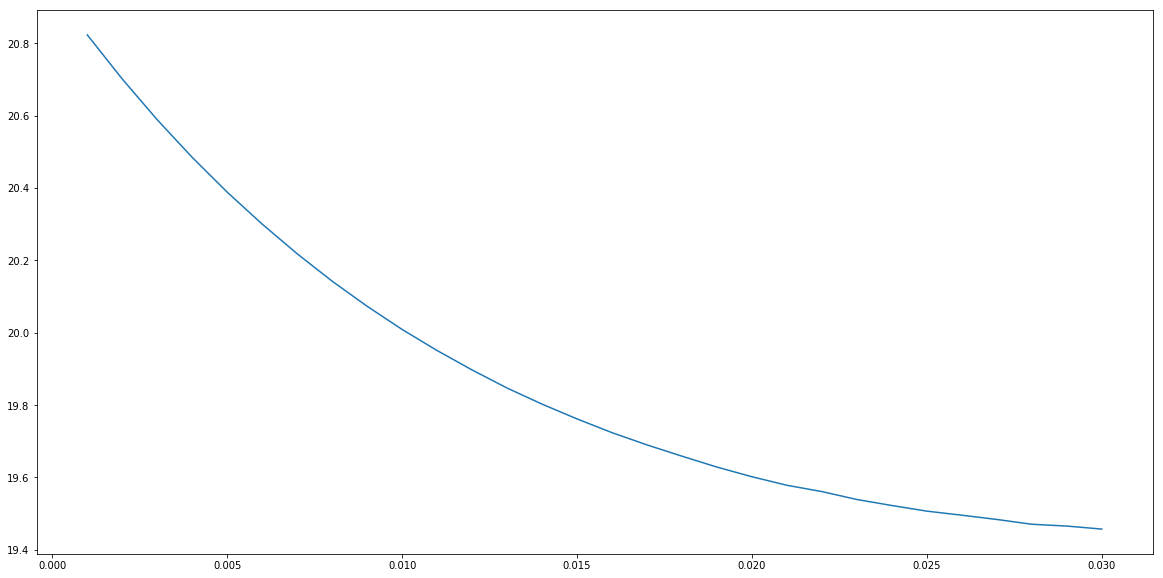

In [340]:
%%time
graph = []
for learning_rate in np.linspace(0.03, 0.001, 30):
    xgb = xgbr(max_depth=max_depth,
               min_child_weight=max_depth,
               gamma=gamma,
               subsample=subsample,
               colsample_bytree=colsample_bytree,
               reg_lambda=reg_lambda,
               reg_alpha=reg_alpha,
               n_estimators=n_estimators,
               nthread=3,
               learning_rate=learning_rate)
    errors = []
    for i in range(1, 1+test_size, 1):
        tr = train[i-1]
        ts = test[i-1]
        for r in kaggle_regions[:]:
            train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
            test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
            train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
            test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
            test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
            xgb.fit(X=train_X, y=train_y)
            prediction = xgb.predict(test_X)
            errors.append(mean(abs(prediction - test_y.values)))
    graph.append([learning_rate, mean(errors)])
    print(graph[-1])
graph = np.array(graph)
learning_rate = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]
print(learning_rate)
plt.figure(figsize=(20,10))
plt.plot(graph[:, 0], graph[:, 1])

## Гиперпараметры подобраны. Можно теперь переходить к обучению xgb regressor на майских данных, прогнозировать данные для июня и складывать их с прогнозами лассо регрессии на признаки тренда, недельной сезонности и праздников.

In [341]:
%%time
xgb = xgbr(max_depth=max_depth,
           min_child_weight=max_depth,
           gamma=gamma,
           subsample=subsample,
           colsample_bytree=colsample_bytree,
           reg_lambda=reg_lambda,
           reg_alpha=reg_alpha,
           n_estimators=n_estimators,
           nthread=3,
           learning_rate=learning_rate)
errors = []
PREDICTION = pd.DataFrame()
for i in range(1, 1+test_size, 1):
    tr = test[i-1] # Tеперь обучение будет идти на майских данных
    ts = submission[i-1] # А предсказываться будут июньские
    for r in kaggle_regions[:]:
        train_Xy = tr[tr['r']==int(r)].drop('r', axis=1)
        test_Xy = ts[ts['r']==int(r)].drop('r', axis=1)
        train_X = train_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
        train_y = train_Xy['y']-train_Xy['lr(i='+str(i)+')']
        test_X = test_Xy.drop(['lr(i='+str(i)+')', 'y'], axis=1)
        test_y = test_Xy['y']-test_Xy['lr(i='+str(i)+')']
        xgb.fit(X=train_X, y=train_y)
        prediction = xgb.predict(test_X)
        prediction = test_Xy['lr(i='+str(i)+')']+prediction
        prediction = prediction.apply(lambda x: max(x, 0)) # Поездок не бывает меньше нуля
        he = pd.Series(prediction.index+datetime.timedelta(hours=-i), name='id').apply(str)
        he = he.apply(lambda x:r+'_'+x[:10]+'_'+str(int(x[11:13]))+'_'+str(i))
        pred_tmp = pd.DataFrame(data = prediction.values, index = he, columns=['y'])
        PREDICTION = pd.concat([PREDICTION, pred_tmp])
        errors.append(mean(abs(data[r][prediction.index].values-prediction.values)))
print('Q_june: '+str(mean(errors)))
PREDICTION.to_csv('my_submission.csv')

Q_june: 18.21513013895784
CPU times: user 2min 44s, sys: 1.31 s, total: 2min 45s
Wall time: 1min 9s


## Прогноз получился точнее, чем на прошлой неделе (Q_june = 26.06)

# Сабмишшен https://www.kaggle.com/submissions/7460936